<a href="https://colab.research.google.com/github/hyeonjun/boostcourse_tensorflow/blob/master/lab_12_5_seq_to_seq_keras_eager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab 12-5 sequence to sequence (Keras + eager version)
simple neural machine translation training
* sequence to sequence

Sequence to Sequence는 번역이나 챗봇 등에서 활용할 수 있다.

Sequence to Sequence는 시퀀스의 입력을 받고 시퀀스의 출력을 하는 모델이다.

그런데 RNN는 이미 시퀀스를 입력받기 위해 만들어졌다고 하였다. 그렇다면 Sequence to Sequence와 일반적인 RNN 모델과의 차이점은 무엇일까?

Sequence to Sequence가 잘 작동하는 대표적인 태스크로는 번역 및 챗봇 등이 있다.

Sequence to Sequence 모델의 대표적인 특징이 아래의 인코더와 디코더 구조다.

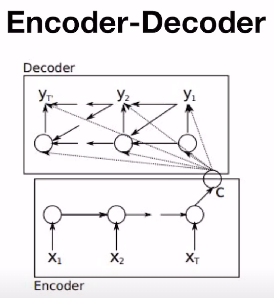

이 Sequence to Sequence 모델은 RNN 모델을 기반으로 하여 모델을 크게 인코더와 디코더 부분으로 나뉜다.

우선 인코더 부분에서 입력 정보를 담은 벡터를 만들어내고, 이후 디코더에서는 이 벡터를 활용하여 재귀적으로 출력값을 만들어내는 구조입니다.

위 그림의 아래쪽에 나와있는 박스가 인코더 RNN step마다 입력값(x1, x2, xT)이 들어가고 있다.

이 입력값들이 하나의 단어가 됐고 인코더 부분의 전체 신경망의 마지막 부분에 C로 표현된 하나의 벡터가 나온다.

이 C라는 벡터가 인코더 부분의 정보를 요약해 담고 있는 벡터이고 정확하게는 RNN의 마지막 hidden vector 값을 사용한다.

이제 디코더 부분으로 들어가서 이 벡터를 사용하여 새롭게 RNN 학습을 시작한다.

그리고 이 신경망의 각 스텝마다 하나씩 출력값이 나오는데 이 출력 역시 하나의 단어가 된다.

디코더 부분의 그림을 자세히 보면 각 스텝에서의 출력값들이 다음 스텝으로 들어가는 구조를 표현하고 있는데, 정확하게 말하면 각 스텝의 출력값이 다음 스텝의 입력값으로 사용된다.




EX)

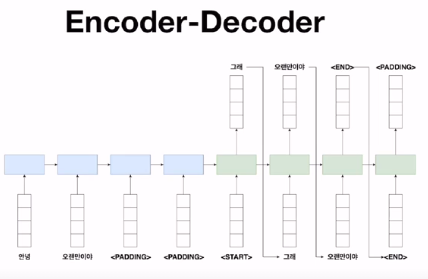

왼쪽에 파란색을 돼있는 부분이 인코더이고 오른쪽에 초록색으로 표현된 부분이 디코더 부분이다.

인코더 부분을 보면 우선 각 신경망의 스텝마다 단어가 하나씩 들어가고 있습니다. 각 단어는 embedding된 후 벡터로 바뀐 후 입력값으로 활용된다. RNN의 경우 구현 시 고정된 문장 길이를 정의해야 되는데 위 그림에서는 인코더와 디코더 모두 문장 길이를 4로 정했다.

하지만 입력값을 생각해보면 안녕과 오랜만이야는 두 단어만 존재하는데 나머지 두 개의 빈 공간을 padding으로 채워 넣어줘야한다.

디코더 부분에는 먼저 최초 입력값은 START라는 특정 토큰을 활용한다. 이 토큰은 문장의 시작을 나타내는 토큰이며 디코더 역시 해당 단어가 embedding vector 형태로 입력값이 들어가고 각 스텝마다 출력이 나온다.

이렇게 나온 출력 단어는 다음 스텝의 입력값으로 사용되는 구조다.

최종적으로 END라는 토큰이 나오면 문장의 끝으로 보는 형태로 학습을 진행한다.



In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

from matplotlib import font_manager, rc

rc('font', family='AppleGothic') #for mac

import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
import numpy as np
import os

In [ ]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [ ]:
# vocabulary for sources
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {source : idx for idx, source in enumerate(s_vocab)}
idx2source = {idx : source for idx, source in enumerate(s_vocab)}

pprint(source2idx)

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}


In [ ]:
# vocabulary for targets
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
# bos : beginning of sentence
# eos : end of sentence
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {target : idx for idx, target in enumerate(t_vocab)}
idx2target = {idx : target for idx, target in enumerate(t_vocab)}

pprint(target2idx)


{'<bos>': 1,
 '<eos>': 2,
 '<pad>': 0,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}


In [ ]:
def preprocess(sequences, max_len, dic, mode='source'):
  assert mode in ['source', 'target'], 'source와 target 중 선택'

  if mode == 'source':
    # preprocessing for source (encoder)
    # 각각의 문장을 입력된 vocab 사전을 바탕으로 치환.
    s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
    s_len = list(map(lambda sentence : len(sentence), s_input))

    # 문장의 index 길이를 맞추기 위하여 padding을 추가로 입력해준다.
    s_input = pad_sequences(sequences = s_input, maxlen=max_len, padding='post', truncating='post')
    return s_len, s_input
  
  elif mode== 'target':
    # preprocessing for target (decoder)
    # input
    # 타켓의 입력값에는 문장의 시작과 끝에 시작과 종료 토큰을 넣어준다.
    t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
    t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
    t_len = list(map(lambda sentence : len(sentence), t_input))
    t_input = pad_sequences(sequences = t_input, maxlen=max_len, padding='post', truncating='post')
    
    # output
    # 타켓의 라벨 값에는 문장 끝에 종료 토큰을 붙여 데이터 전처리.
    t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
    t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
    t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding='post', truncating='post')

    return t_len, t_input, t_output


In [ ]:
# preprocessing for source
s_max_len = 10
s_len, s_input = preprocess(sequences = sources,
                            max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 7, 5] [[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [ ]:
# preprocessing for target
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets, max_len=t_max_len, dic=target2idx, mode='target')

print(t_len, t_input, t_output)

[5, 5, 6, 6] [[ 1  4  7  3  2  0  0  0  0  0  0  0]
 [ 1 12  6 10  2  0  0  0  0  0  0  0]
 [ 1 12  5 11 13  2  0  0  0  0  0  0]
 [ 1 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  2  0  0  0  0  0  0  0  0]
 [12  6 10  2  0  0  0  0  0  0  0  0]
 [12  5 11 13  2  0  0  0  0  0  0  0]
 [12  6  9  8  2  0  0  0  0  0  0  0]]


In [ ]:
# hyper-parameter
epochs = 200
batch_size = 4
learning_rate = .005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size//batch_size
embedding_dim=32
units = 32

# input
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)
# s_mb_len, s_mb_input, t_mb_len, t_mb_input, t_mb_output = iterator.get_next()

In [ ]:
def gru(units):
  # 입력값의 초기화 진행 시 사용하는 glorot_uniform
  # 이것은 xavier initialization과 같은 의미이고,
  # 초기화 할 때 랜덤으로 했을 때의 weight가 saturated 되거나
  # dead region에서 시작되는 것을 방지해주는 효과가 있다.
  # 즉, 랜덤 값이 너무 작거나 크게 초기화되는 것을 방지.
  return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
  

In [ ]:
class Encoder(tf.keras.Model):
  # 입력 인자로 단어의 크기, embedding의 차원수, 인코더의 hidden_size, batch_size
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_sz = batch_size
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.enc_units)
  
  # 소스 인풋을 기반으로 각각 입력을 embedding layer에 통과시킨 후
  # 생성자 init에서 선언한 GRU layer를 활용하여 output과 states를 출력하는 구조.
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state
  
  # 처음에 GRU 레이어에 입력으로 들어가기 위해
  # 생성되는 더미 입력값.
  def initalize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class Decoder(tf.keras.Model):
  # 입력 인자로 단어의 크기, embedding의 차원수, 디코더의 hidden_size, batch_size
  # 인코더와의 차이점은 마지막에 출력해야되는 fully connected layer(self.fc) 하나 더 추가.
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_sz = batch_size
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.dec_units)
    self.fc = tf.keras.layers.Dense(vocab_size)
  
  # 입력값을 embedding 및 GRU 레이어에 통과시키고
  # 초기 hidden states를 설정하는 방법은 인코더에서 선언한 방법과 똑같다.
  # 마지막에 디코더와 인코더의 차이점인 fully connected layer에 입력한다.
  def call(self, x, hidden, enc_output):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size * 1, vocab)
    x = self.fc(output)
    return x, state
  # 초기 hidden states를 설정하는 방법은 인코더와 동일
  def initalize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.dec_units))

In [ ]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)


In [ ]:
def loss_function(real, pred):
  # 마스크 값 구성
  mask = 1 - np.equal(real, 0)
  # 0으로 된 기존에 설정된 padding된 값을 cross entropy logits를 구할 때 영향을 받지
  # 않도록 mask를 직접 곱해준다.
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  # print("real: {}".format(real))
  # print("pred: {}".format(pred))
  # print("mask: {}".format(mask))
  # print("loss: {}".format(tf.reduce_mean(loss)))

  # 이후 loss의 총 합의 평균을 구하여 리턴
  return tf.reduce_mean(loss)

# creating optimizer
# optimizer는 Adam optimizer를 활용
optimizer = tf.keras.optimizers.Adam()

# creating check point (Object-based saving)
checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)
# create writer for tensorboard
#summary_writer = tf.summary.create_file_writer(logdir=checkpoint_dir)


In [ ]:
for epoch in range(epochs):
  hidden = encoder.initalize_hidden_state()
  total_loss = 0

  # tf.data를 이전에 생성해놨던 데이터를 기반으로
  # 각 소스의 입력값들과 타겟의 입력 및 레이블 값들을 load하여 학습을 진행.
  for i, (s_len, s_input, t_len, t_input, t_ouput) in enumerate(data):
    loss = 0
    with tf.GradientTape() as tape:
      # 인코더의 최종 출력은
      enc_output, enc_hidden = encoder(s_input, hidden)
      # 디코더의 첫 hidden vector로 대입.
      dec_hidden = enc_hidden
      # 디코더의 첫 입력 문장에는 시작을 의미하는 bos 토큰을 넣어주고 학습.
      dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)

      # Teacher Forcing : feeding the target as the next input
      # 그리고 예측값과 디코더의 hidden 값을 통해 학습.
      for t in range(1, t_input.shape[1]):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function(t_input[:, t], predictions)
        # 디코더에서 학습을 할 때 이전 스텝의 정답 단어들을
        # 다음 스텝 입력값으로 넣어주는 teacher forcing 이라는 테크닉을 사용
        # t_input[:, t]
        dec_input = tf.expand_dims(t_input[:, t], 1) # using teacher forcing
    
    batch_loss = (loss / int(t_input.shape[1]))
    total_loss += batch_loss # total loss를 구함
    # 이후에 학습하면서 업데이트될 파라미터들을 variables에 저장
    # 여기서는 인코더의 variables와 디코더의 variables를 더해서 저장
    variables = encoder.variables + decoder.variables
    gradient = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradient, variables))
  
  if epoch % 10 == 0:
    # save model every 10 epoch
    print("epoch {} loss {:.7f} batch_loss {:.7f}".format(epoch, total_loss/n_batch, batch_loss.numpy()))
    checkpoint.save(file_prefix = checkpoint_prefix)

epoch 0 loss 0.0042410 batch_loss 0.1060262
epoch 10 loss 0.0039852 batch_loss 0.0996293
epoch 20 loss 0.0037860 batch_loss 0.0946508
epoch 30 loss 0.0036303 batch_loss 0.0907572
epoch 40 loss 0.0035069 batch_loss 0.0876719
epoch 50 loss 0.0034072 batch_loss 0.0851799
epoch 60 loss 0.0033243 batch_loss 0.0831079
epoch 70 loss 0.0032509 batch_loss 0.0812713
epoch 80 loss 0.0031777 batch_loss 0.0794430
epoch 90 loss 0.0030944 batch_loss 0.0773610
epoch 100 loss 0.0029779 batch_loss 0.0744481
epoch 110 loss 0.0027828 batch_loss 0.0695689
epoch 120 loss 0.0025021 batch_loss 0.0625515
epoch 130 loss 0.0022188 batch_loss 0.0554694
epoch 140 loss 0.0019972 batch_loss 0.0499307
epoch 150 loss 0.0018395 batch_loss 0.0459870
epoch 160 loss 0.0017246 batch_loss 0.0431144
epoch 170 loss 0.0016315 batch_loss 0.0407874
epoch 180 loss 0.0015328 batch_loss 0.0383206
epoch 190 loss 0.0013654 batch_loss 0.0341344


# Teacher Forcing

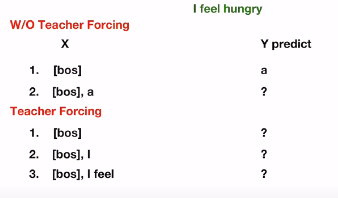




 예를 들어, 예제 데이터 중 한 개인 I feel hungry라는 문장이 있을 때 X에 대해서 처음으로 문장의 시작을 알리는 bos 토큰이 주어졌다고 하면 이후 Y의 예측값이 a가 나왔다고 하자.

Y의 출력값은 원래대로라면 문장의 첫 번째인 I가 나와야 정상이다.

bos 토큰 이후에 Y가 잘못 예측한 a가 들어간다고하면 그 다음 단어를 예측하였을 때 이미 예측 자체가 틀렸기 때문에 모델에게 큰 punishment를 제공하고 문장의 시퀀스를 학습하고 예측하는 Sequence to Seqence 모델에서 학습을 느리게 만들고 못하게 하는 현상이 발생한다.

따라서 우리가 Y가 무엇을 예측하든지 간에 실제 이전 스텝의 정답 단어들을 입력으로 넣음으로써 예측하도록 한다.

Teacher Forcing 부분을 보면 Y가 어떤 걸 예측하던지 간에 그 다음 입력은 정답인 I와 I feel의 입력이 들어간다.

이 방법을 통하여 조금 더 빠르고 효과적으로 RNN 계열을 학습할 수 있다.



In [ ]:
# restore checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# 문장과 학습에서 학습도니 인코더와 디코더, 각각의 입력과 타겟 사전, 최대 길이를 나타내는 입력과 타겟을 입력으로 받는다.
def prediction(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
  # 주어진 문장을 띄어쓰기로 쪼개어 inp_lang의 사전을 기반으로 인덱싱화 해준다.
  inputs = [inp_lang[i]for i in sentence.split(' ')]
  # 전처리에서 했던 것처럼 padding으로 길이를 맞춰준다.
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  # 학습에서 진행되었던 것처럼 인코더의 hidden 값을 디코더의 첫 hidden 값을 입력으로 받고
  enc_out, enc_hidden = encoder(inputs, hidden)
  
  dec_hidden = enc_hidden
  # 문장의 시작을 알리는 토큰<bos>을 디코더의 입력으로 하여 예측 시작.
  dec_input = tf.expand_dims([targ_lang['<bos>']], 0)

  # 각 값들을 타겟의 최대 길이만큼 반복하면서 id 값을 예측
  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)
    predicted_id = tf.argmax(predictions[0]).numpy()


    # 만약에 id 값이 eos 토큰으로 예측하면 예측을 중비하고 결과값을 반환
    if idx2target.get(predicted_id) == '<eos>':
      return result, sentence
      
    # 인덱스 문장을 치환하여 띄어쓰기를 기준으로 합쳐 result에 저장
    result += idx2target[predicted_id] + ' '
    
    # the predicted ID is fed back input the model
    dec_input = tf.expand_dims([predicted_id], 0)
  return result, sentece 

In [ ]:
sentence1 = 'tensorflow is a framework for deep learning'
sentence2 = 'I feel hungry'

In [ ]:
result, output_sentence = prediction(sentence1, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)

print(sentence1)
print(result)
print(output_sentence)

result, output_sentence = prediction(sentence2, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)

print(sentence2)
print(result)
print(output_sentence)

tensorflow is a framework for deep learning
텐서플로우는 딥러닝을 위한 프레임워크이다 
tensorflow is a framework for deep learning
I feel hungry
나는 배가 고프다 
I feel hungry
